In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# for statistics
from scipy.stats import kstest

# preprocessing
from sklearn.preprocessing import StandardScaler

# ml methods
from sklearn.ensemble import IsolationForest

# metrics
from sklearn.metrics import f1_score

# Datasets

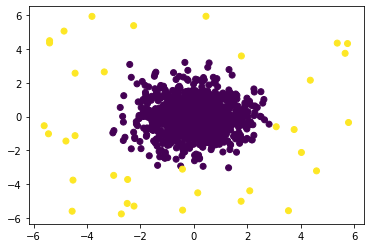

In [6]:
# Синтетически сгенерированные нормально распределенные данные
data_norm = pd.DataFrame(data=np.random.normal(
                        loc=0, scale=1, size=(1000, 2)), 
                       columns=['x', 'y'])
data_noise = pd.DataFrame(data=np.random.uniform(
                        low=-6, high=6, size=(int(data_norm.shape[0]*.05), data_norm.shape[1])), 
                        columns=['x', 'y'])
filter = (
    (data_noise['x'] < data_norm['x'].min())
    | (data_noise['x'] > data_norm['x'].max())
    | (data_noise['y'] < data_norm['y'].min())
    | (data_noise['y'] > data_norm['y'].max())
    )
data_noise = data_noise[filter]
data_norm['anomaly'] = 0
data_noise['anomaly'] = 1

df_norm = pd.concat((data_norm, data_noise))
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.show()

In [ ]:
# SKAB data

# from google.colab import drive
# drive.mount('/content/drive')
# ! cp -r /content/drive/MyDrive/Study/MIPT_magistery/qualification_work/data .


all_files=[]
import os
for root, dirs, files in os.walk("data/"):
    for file in files:
        if file.endswith(".csv"):
             all_files.append(os.path.join(root, file))

# формируем датафрейм
dfs=[]
for path in all_files:
    df = pd.read_csv(path,index_col='datetime',sep=';',parse_dates=True)
    print(path, df.shape)
    dfs.append(df)
print('Features:')
for col in dfs[2].columns:
    print('\t',col)
dfs = [df for df in dfs if df.shape[1] == 10]
df_skab = pd.concat(dfs)
df_skab = df_skab.drop_duplicates()
df_skab = df.drop('changepoint', axis=1)
display(df_skab)

# Статический метод выявления выбросов (3 сигма)

In [7]:
def check_kstest(df, alpha=0.05):
    columns = list(df.columns)
    cols_with_pos_res = []
    for col in columns:
        if kstest(df[col], 'norm').pvalue > alpha:
            cols_with_pos_res.append(col)
    return cols_with_pos_res

def outliers_z_score(data, feature):
    x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    print(f'Признак {feature}. Число выбросов по методу z-отклонения: {outliers.shape[0]}')
    return outliers

def z_score_method(df):
    """
    Метод работает с нормально распределенными данными,
    при чем с небольшим (до 10%) количеством выбросов.
    С ненормально распределенными данными не работает.
    """
    norm_cols = check_kstest(df)
    if norm_cols:
        outliers = pd.DataFrame()
        for col in norm_cols:
            outliers = pd.concat((outliers, outliers_z_score(df, col)))
        outliers = outliers.drop_duplicates()
        outliers['anomaly_preds'] = 1
        df_with_marked_outliers = df.merge(outliers, how='outer').fillna(0)
        return outliers, df_with_marked_outliers
    else:
        print('The data are not normally distributed')
        return None, df

# Метрики

In [31]:
# f1_score
def score_metrics(real_outliers, pred_outliers):
    scores = {}
    scores['f1_score'] = f1_score(real_outliers, pred_outliers)
    return scores

Ищем выбросы

In [32]:
outliers, df_norm = z_score_method(df_norm)
if outliers is not None:
    print(score_metrics(df_norm['anomaly'], df_norm['anomaly_preds']))

Признак x. Число выбросов по методу z-отклонения: 19
Признак y. Число выбросов по методу z-отклонения: 20
{'f1_score': 0.923076923076923}


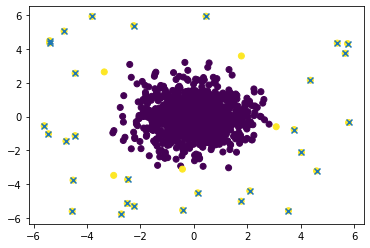

In [33]:
plt.scatter(df_norm['x'], df_norm['y'], c=df_norm['anomaly'])
plt.scatter(outliers['x'], outliers['y'], marker='x')
plt.show()

In [ ]:
outliers, df_skab = z_score_method(df_skab)

# ML методы

## Unsupervised

In [ ]:
X = df_skab.copy()
y = X.pop('anomaly')

# preprocessing
columns = list(X.columns)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(data=X, columns=columns)

# IsolationForest
iForest = IsolationForest(n_estimators=50, verbose=1)
iForest.fit(X)
pred = iForest.predict(X)
pred[pred == 1] = 0
pred[pred == -1] = 1
f1_score(y, pred)

((36920, 8), (36920,))

## Semi-supervised